# Search

Searching for products is one of the most important features of `eodag`. This page describes the different methods available to search for products and the parameters that these methods accept.

You will learn how to deal with:
- [Pagination](#Pagination)  
- [Search methods](#Search-methods)  
- [SearchResult and EOProduct](#Searchresult-and-EOproduct)  
- [Search parameters](#Search-parameters)  
- [Guess a collection](#Guess-a-collection)  
- [Fallback in case of error](#Fallback-in-case-of-error)

`eodag` is set here to search for *Sentinel 2 Level-1C* products with *PEPS*.

In [1]:
from eodag import EODataAccessGateway
from eodag import setup_logging
setup_logging(2)

dag = EODataAccessGateway()
dag.set_preferred_provider("peps")

2025-10-17 18:12:29,090 eodag.config                     [INFO    ] Loading user configuration from: /home/sylvain/.config/eodag/eodag.yml
2025-10-17 18:12:29,231 eodag.core                       [INFO    ] Locations configuration loaded from /home/sylvain/.config/eodag/locations.yml


A default set of search criteria is defined, the area of interest is in the South-West of France, and `count` is enabled.

In [2]:
default_search_criteria = {
    "collection": "S2_MSI_L1C",
    "start": "2021-03-01",
    "end": "2021-03-31",
    "geom": {"lonmin": 1, "latmin": 43, "lonmax": 2, "latmax": 44},
    "count": True
}

A set of default values can be configured for each collection of a provider. This is configured in `providers.yml` as described in the section ["Add a collection"](../../add_collection.rst). No default value is available for all ECMWF-like providers: `ecmwf`, `cop_ads`, `cop_cds`, `meteoblue`, `wekeo_ecmwf`, `dedt_lumi`, and `cop_ewds`. The [`list_queryables`](5_queryables.ipynb) method can be used to know which query parameters can be used to filter the search result.

## Pagination

A [Google search](https://www.google.com/search?q=eodag) displays the first result page, which has 10 items (i.e. URLs). An action is required to get the next results, i.e. the second page, which would also contain 10 items. This process has the advantage of sending less data through the web, as a consequence the results are displayed faster. And after all, in most cases the URLs obtained from the first page are enough.

Pagination is what is described above. Most EO product providers operate this way, they return by default the first page result with a given number of items (i.e. products). Since pagination is ubiquitous among providers, it is built deep into `eodag` too and its search capabilities.

## Search methods

The three search methods introduced below accept pretty much the same parameters, which are described further down the page.

### [search()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.search)

[search()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.search) was the first search method implemented in `eodag`. It returns a [SearchResult](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) that stores the products obtained from the first page having a given maximum **number of items per page**. The attribute [SearchResult.number_matched](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) optionally stores the **estimated** total number of products matching the search criteria.

By default, [search()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.search) **returns the products from the first page with a maximum of 20 products**. This means
that it is often expected to obtain a [SearchResult](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) that contains 20 products and a much larger estimated
total number of products available.

<div class="alert alert-warning">

Warning

The [SearchResult.number_matched](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) attribute is the **estimated** total number of products matching the search criteria, since, unfortunately, all the providers do not return the **exact** total number.

</div>

Pagination can be controlled with the optional parameter `items_per_page` and the method `next_page` described below.

In [3]:
products_first_page = dag.search(**default_search_criteria)

2025-10-17 18:13:16,886 eodag.core                       [INFO    ] Searching on provider peps
2025-10-17 18:13:16,907 eodag.search.qssearch            [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?startDate=2021-03-01&completionDate=2021-03-31&geometry=POLYGON ((1.0000 43.0000, 1.0000 44.0000, 2.0000 44.0000, 2.0000 43.0000, 1.0000 43.0000))&productType=S2MSI1C&maxRecords=20&page=1
2025-10-17 18:13:27,605 eodag.core                       [INFO    ] Found 48 result(s) on provider 'peps'


In [4]:
print(f"Got a hand on {len(products_first_page)} products and an estimated total number of {products_first_page.number_matched} products available.")

Got a hand on 20 products and an estimated total number of 48 products available.


In [5]:
new_search_with_less_elements = dag.search(items_per_page=5, **default_search_criteria)
new_search_with_less_elements

2025-10-17 18:13:27,627 eodag.core                       [INFO    ] Searching on provider peps
2025-10-17 18:13:27,662 eodag.search.qssearch            [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?startDate=2021-03-01&completionDate=2021-03-31&geometry=POLYGON ((1.0000 43.0000, 1.0000 44.0000, 2.0000 44.0000, 2.0000 43.0000, 1.0000 43.0000))&productType=S2MSI1C&maxRecords=10&page=2
2025-10-17 18:13:29,896 eodag.core                       [INFO    ] Found 48 result(s) on provider 'peps'


SearchResult([EOProduct(id=S2B_MSIL1C_20210328T103629_N0500_R008_T31TDH_20230602T033834, provider=peps),
              EOProduct(id=S2B_MSIL1C_20210328T103629_N0500_R008_T31TCJ_20230602T033834, provider=peps),
              EOProduct(id=S2B_MSIL1C_20210328T103629_N0500_R008_T31TDJ_20230602T033834, provider=peps),
              EOProduct(id=S2B_MSIL1C_20210328T103629_N0500_R008_T31TCH_20230602T033834, provider=peps),
              EOProduct(id=S2A_MSIL1C_20210326T105031_N0500_R051_T31TCJ_20230515T023730, provider=peps)])

In [6]:
print(f"Got a hand on {len(new_search_with_less_elements)} products and an estimated total number of {new_search_with_less_elements.number_matched} products available.")

Got a hand on 5 products and an estimated total number of 48 products available.


<div class="alert alert-warning">

Warning

To get all the products available, it would seem natural to set `items_per_page` to a very high value
(e.g. 10000). However, the providers usually have set a maximum number of products/items that can be
requested in a single query. If `items_per_page` is set to a value higher than this provider's limit, the
search may either return an empty [SearchResult](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) or fail and raise an error.

</div>

#### Error handling
The `raise_errors` parameter controls how errors raised internally during a search are propagated to the user. By default this parameter is set to `False`, which means that **errors are not raised**. Instead, errors are logged and an empty [SearchResult](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) is returned. The use of the `provider` parameter and the error raised in the example below are explained in [the id and provider sub-section](#id-and-provider) and [the fallback section](#fallback-in-case-of-error) respectively.

In [7]:
bad_search_criteria = default_search_criteria.copy()
bad_search_criteria["start"] = "malformed_start_date"

In [8]:
failed_search_result = dag.search(provider="peps", **bad_search_criteria)

2025-10-17 18:13:35,535 eodag.core                       [INFO    ] Searching on provider peps
2025-10-17 18:13:35,558 eodag.search.qssearch            [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?startDate=malformed_start_date&completionDate=2021-03-31&geometry=POLYGON ((1.0000 43.0000, 1.0000 44.0000, 2.0000 44.0000, 2.0000 43.0000, 1.0000 43.0000))&productType=S2MSI1C&maxRecords=20&page=1
2025-10-17 18:13:36,025 eodag.search.qssearch            [ERROR   ] Skipping error while searching for peps QueryStringSearch instance 
Traceback (most recent call last):
  File "/home/sylvain/workspace/eodag/eodag/plugins/search/qssearch.py", line 1284, in _request
    response.raise_for_status()
  File "/home/sylvain/workspace/eodag/.venv/lib/python3.9/site-packages/requests/models.py", line 1026, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 400 Client Error: Bad Request for url: https://pep

In [9]:
failed_search_result

SearchResult([])

In [10]:
print(f"Got a hand on {len(failed_search_result)} products and an estimated total number of {failed_search_result.number_matched} products available.")

Got a hand on 0 products and an estimated total number of 0 products available.


Setting this parameter to `True` does propagate errors.

In [11]:
failed_search_result = dag.search(**bad_search_criteria, raise_errors=True)

2025-10-17 18:13:44,165 eodag.core                       [INFO    ] Searching on provider peps
2025-10-17 18:13:44,191 eodag.search.qssearch            [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?startDate=malformed_start_date&completionDate=2021-03-31&geometry=POLYGON ((1.0000 43.0000, 1.0000 44.0000, 2.0000 44.0000, 2.0000 43.0000, 1.0000 43.0000))&productType=S2MSI1C&maxRecords=20&page=1
2025-10-17 18:13:44,625 eodag.search.qssearch            [ERROR   ] Skipping error while searching for peps QueryStringSearch instance 
Traceback (most recent call last):
  File "/home/sylvain/workspace/eodag/eodag/plugins/search/qssearch.py", line 1284, in _request
    response.raise_for_status()
  File "/home/sylvain/workspace/eodag/.venv/lib/python3.9/site-packages/requests/models.py", line 1026, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 400 Client Error: Bad Request for url: https://pep

RequestError: ('Skipping error while searching for peps QueryStringSearch instance', ' {"ErrorMessage":"Value for \\"startDate\\" must follow the pattern ^[0-9]{4}-[0-9]{2}-[0-9]{2}(T[0-9]{2}:[0-9]{2}:[0-9]{2}(\\\\.[0-9]+)?(|Z|[\\\\+\\\\-][0-9]{2}:[0-9]{2}))?$","ErrorCode":400}')

### [search_all()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.search_all)

[search_all()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.search_all) takes the pain away from thinking about pagination. It returns a [SearchResult](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) that contains **all** the products matching the search criteria. It does so by iterating over the pages of a search result (with [SearchResult.next_page()](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult.next_page)) and gathering products. Compared to [search()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.search):

* The attribute [SearchResult.number_matched](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) is `None`. The estimate of total number of products available isn't required here, since they all get collected anyway. This also spares some requests to be sent, since the estimate is usually obtained by sending an additional request.

* It tries to optimize the number of items/products requested per page. The limit of most providers has been configured in `eodag`, it is used if available (e.g. 500 products per page). If not available, a default value of 50 is used. An arbitrary value can also be used.

* It has no `raise_errors` parameter, errors are not caught.
  
* `count` is not available for this method, as it will be directly [SearchResult](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) length.

In [12]:
all_products = dag.search_all(**default_search_criteria)

2025-10-17 18:13:47,814 eodag.core                       [INFO    ] Searching for all the products with provider peps and a maximum of 500 items per page.
2025-10-17 18:13:47,817 eodag.core                       [INFO    ] Iterate search over multiple pages: page #1
2025-10-17 18:13:47,819 eodag.core                       [INFO    ] Searching on provider peps
2025-10-17 18:13:47,842 eodag.search.qssearch            [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?startDate=2021-03-01&completionDate=2021-03-31&geometry=POLYGON ((1.0000 43.0000, 1.0000 44.0000, 2.0000 44.0000, 2.0000 43.0000, 1.0000 43.0000))&productType=S2MSI1C&maxRecords=500&page=1
2025-10-17 18:13:51,443 eodag.core                       [INFO    ] Found 48 result(s) on provider 'peps'


In [13]:
print(f"Got a hand on a total number of {len(all_products)} products.")

Got a hand on a total number of 48 products.


The parameter `items_per_page` controls the maximum number of products than can be retrieved at each iteration internally.

In [13]:
all_products = dag.search_all(**default_search_criteria, items_per_page=30)

2025-10-17 18:14:00,630 eodag.core                       [INFO    ] Searching for all the products with provider peps and a maximum of 30 items per page.
2025-10-17 18:14:00,634 eodag.core                       [INFO    ] Iterate search over multiple pages: page #1
2025-10-17 18:14:00,636 eodag.core                       [INFO    ] Searching on provider peps
2025-10-17 18:14:00,660 eodag.search.qssearch            [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?startDate=2021-03-01&completionDate=2021-03-31&geometry=POLYGON ((1.0000 43.0000, 1.0000 44.0000, 2.0000 44.0000, 2.0000 43.0000, 1.0000 43.0000))&productType=S2MSI1C&maxRecords=30&page=1
2025-10-17 18:14:03,527 eodag.core                       [INFO    ] Iterate search over multiple pages: page #2
2025-10-17 18:14:03,527 eodag.core                       [INFO    ] Searching on provider peps
2025-10-17 18:14:03,548 eodag.search.qssearch            [INFO    ] Sending search request: 

The logs show that two requests have been sent to gather all the products, while only one was required in the previous case where [search_all()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.search_all) used internally a limit higher than 48.

## [SearchResult](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) and [EOProduct](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct)

Each search method returns an instance of the [SearchResult](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) class. This object is a sequence that stores a number of [EOProduct](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct) instances. A [SearchResult](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) supports some of the capabilities of a classic Python `list` object.

In [16]:
all_products[:2]

SearchResult([EOProduct(id=S2B_MSIL1C_20210328T103629_N0500_R008_T31TDH_20230602T033834, provider=peps),
              EOProduct(id=S2B_MSIL1C_20210328T103629_N0500_R008_T31TCJ_20230602T033834, provider=peps)])

An [EOProduct](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct) is the representation of an EO product for `eodag`, it stores enough information about how it was obtained (search criteria, provider) and about how to download itself. Most importantly it stores all the metadata that have been acquired by `eodag` during the search made

In [17]:
one_product = all_products[0]
one_product

EOProduct(id=S2B_MSIL1C_20210328T103629_N0500_R008_T31TDH_20230602T033834, provider=peps)

An [EOProduct](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct) has the following attributes:

* `properties`: dictionary of the product's metadata
* `geometry`: the product's geometry as a `shapely.geometry` object
* `provider`: the provider used to obtain this product
* `collection`: `eodag`'s identifier of its collection
* `search_kwargs`: a dictionary of the search criteria used to find the product.
* `remote_location`: the URL to the product's download link
* `location`: it is equal to `remote_location` before the product is downloaded. Once downloaded, it is updated to the absolute local path to the product.

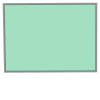

In [18]:
one_product.geometry

In [18]:
one_product.provider, one_product.collection

('peps', 'S2_MSI_L1C')

In [19]:
one_product.search_kwargs

{'collection': 'S2_MSI_L1C',
 'start_datetime': '2021-03-01',
 'end_datetime': '2021-03-31',
 'geometry': <POLYGON ((1 43, 1 44, 2 44, 2 43, 1 43))>}

In [20]:
one_product.remote_location, one_product.location

('https://peps.cnes.fr/resto/collections/S2ST/2d85d4c8-34c1-55dc-b43c-0ab0fe4c2b97/download',
 'https://peps.cnes.fr/resto/collections/S2ST/2d85d4c8-34c1-55dc-b43c-0ab0fe4c2b97/download')

In [21]:
one_product.properties.keys()

dict_keys(['constellation', 'created', 'description', 'end_datetime', 'gsd', 'id', 'instruments', 'keywords', 'platform', 'providers', 'published', 'start_datetime', 'title', 'uid', 'updated', 'eo:cloud_cover', 'eo:snow_cover', 'eodag:download_link', 'eodag:quicklook', 'eodag:thumbnail', 'grid:code', 'order:status', 'peps:bareSoil', 'peps:bucket', 'peps:highProbaClouds', 'peps:isNrt', 'peps:isRefined', 'peps:lowProbaClouds', 'peps:mediumProbaClouds', 'peps:newVersion', 'peps:nrtResource', 'peps:parentIdentifier', 'peps:prefix', 'peps:realtime', 'peps:relativeOrbitNumber', 'peps:resourceChecksum', 'peps:resourceSize', 'peps:s2TakeId', 'peps:snowIce', 'peps:storage', 'peps:useDatalake', 'peps:vegetation', 'peps:visible', 'peps:water', 'processing:level', 'product:type', 'sar:instrument_mode', 'sat:absolute_orbit', 'sat:orbit_state'])

An [EOProduct](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct) has an [as_dict()](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct.as_dict) to convert it into a GeoJSON-like dictionary and a [from_geojson()](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct.from_geojson) method to create an [EOProduct](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct) from a GeoJSON dictionary.

In [22]:
from eodag import EOProduct
product_geojson_structure = one_product.as_dict()
recreated_product = EOProduct.from_geojson(product_geojson_structure)
recreated_product

EOProduct(id=S2B_MSIL1C_20210328T103629_N0500_R008_T31TDH_20230602T033834, provider=peps)

Since [EOProduct](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct)s have a way to convert themselves to a GeoJSON dictionary, it is natural to be able to convert a [SearchResult](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) object to a GeoJSON *FeatureCollection* ([as_geojson_object()](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult.as_geojson_object)). It is also possible to create a [SearchResult](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) from a dictionary structured as a *FeatureCollection* with [from_geojson()](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult.from_geojson).

In [23]:
from eodag import SearchResult
feature_collection = all_products.as_geojson_object()
recreated_search_result = SearchResult.from_geojson(feature_collection)
recreated_search_result[:2]

SearchResult([EOProduct(id=S2B_MSIL1C_20210328T103629_N0500_R008_T31TDH_20230602T033834, provider=peps),
              EOProduct(id=S2B_MSIL1C_20210328T103629_N0500_R008_T31TCJ_20230602T033834, provider=peps)])

You can also convert a [SearchResult](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) object to other formats, like `shapely.geometry.GeometryCollection` ([as_shapely_geometry_object()](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult.as_shapely_geometry_object)), and `WKT` ([as_wkt_object()](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult.as_wkt_object)).

<div class="alert alert-info">

Note

[EOProduct](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct) and [SearchResult](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) objects have more methods and attributes than the ones listed aboved.
They are gradually introduced in the next pages of this user guide.

</div>

<div class="alert alert-info">

Note

When [eodag-cube](https://github.com/CS-SI/eodag-cube) is installed the [EOProduct](../../api_reference/eoproduct.rst#eodag.api.product._product.EOProduct) class used by `eodag` is the one provided by [eodag-cube](https://github.com/CS-SI/eodag-cube), which extends it with a few more capabilities, including a [to_xarray()](../../api_reference/eoproduct.rst#eodag_cube.api.product._product.EOProduct.to_xarray) method to directly access the product's data.

</div>

### Next pages iteration

[SearchResult](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) objects have the [next_page()](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult.next_page) method that retrieves and iterates over the next pages of results, if available.

This can be usefull if you need to manually iterate over pages rather than using [search_all()](#search_all()).

But while [search_all()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.search_all) optimizes the number of items per page requested by iteration, [search_iter_page()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.search_iter_page) uses a default value of 20, which can be set to any arbitrary value.

The method returns an iterator page per page, and updates the original search result with new results by default:

In [24]:
search_results = dag.search(**default_search_criteria)

print(f"Got {len(search_results)} products on first page")

for new_results in search_results.next_page():
    print(f"Got {len(new_results)} new products, {len(search_results)} in updated search result")

2025-09-23 21:22:46,199 eodag.core                       [INFO    ] Searching on provider peps
2025-09-23 21:22:46,204 eodag.search.qssearch            [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?startDate=2021-03-01&completionDate=2021-03-31&geometry=POLYGON ((1.0000 43.0000, 1.0000 44.0000, 2.0000 44.0000, 2.0000 43.0000, 1.0000 43.0000))&productType=S2MSI1C&maxRecords=20&page=1
2025-09-23 21:22:47,740 eodag.core                       [INFO    ] Searching on provider peps
2025-09-23 21:22:47,741 eodag.search.qssearch            [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?startDate=2021-03-01&completionDate=2021-03-31&geometry=POLYGON ((1.0000 43.0000, 1.0000 44.0000, 2.0000 44.0000, 2.0000 43.0000, 1.0000 43.0000))&number_matched=48&productType=S2MSI1C&maxRecords=20&page=2


Got 20 products on first page


2025-09-23 21:22:49,269 eodag.core                       [INFO    ] Searching on provider peps
2025-09-23 21:22:49,271 eodag.search.qssearch            [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?startDate=2021-03-01&completionDate=2021-03-31&geometry=POLYGON ((1.0000 43.0000, 1.0000 44.0000, 2.0000 44.0000, 2.0000 43.0000, 1.0000 43.0000))&number_matched=48&productType=S2MSI1C&maxRecords=20&page=3


Got 20 new products, 40 in updated search result
Got 8 new products, 48 in updated search result


or shorter, using [deque](https://docs.python.org/3.13/library/collections.html#deque-objects):

In [25]:
from collections import deque

search_results = dag.search(**default_search_criteria)
deque(search_results.next_page())

print(f"Got {len(search_results)} products")

2025-09-23 21:22:50,208 eodag.core                       [INFO    ] Searching on provider peps
2025-09-23 21:22:50,212 eodag.search.qssearch            [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?startDate=2021-03-01&completionDate=2021-03-31&geometry=POLYGON ((1.0000 43.0000, 1.0000 44.0000, 2.0000 44.0000, 2.0000 43.0000, 1.0000 43.0000))&productType=S2MSI1C&maxRecords=20&page=1
2025-09-23 21:22:51,820 eodag.core                       [INFO    ] Searching on provider peps
2025-09-23 21:22:51,823 eodag.search.qssearch            [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?startDate=2021-03-01&completionDate=2021-03-31&geometry=POLYGON ((1.0000 43.0000, 1.0000 44.0000, 2.0000 44.0000, 2.0000 43.0000, 1.0000 43.0000))&number_matched=48&productType=S2MSI1C&maxRecords=20&page=2
2025-09-23 21:22:53,404 eodag.core                       [INFO    ] Searching on provider peps
2025-09-23 21:22:

Got 48 products


If you prefer not updating original [SearchResult](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult), set `update` parameter to `False`:

In [26]:
search_results = dag.search(**default_search_criteria)

print(f"Got {len(search_results)} products on first page")

for new_results in search_results.next_page(update=False):
    print(f"Got {len(new_results)} new products, still {len(search_results)} products in original search result")

2025-09-23 21:22:54,380 eodag.core                       [INFO    ] Searching on provider peps
2025-09-23 21:22:54,386 eodag.search.qssearch            [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?startDate=2021-03-01&completionDate=2021-03-31&geometry=POLYGON ((1.0000 43.0000, 1.0000 44.0000, 2.0000 44.0000, 2.0000 43.0000, 1.0000 43.0000))&productType=S2MSI1C&maxRecords=20&page=1
2025-09-23 21:22:55,944 eodag.core                       [INFO    ] Searching on provider peps
2025-09-23 21:22:55,946 eodag.search.qssearch            [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?startDate=2021-03-01&completionDate=2021-03-31&geometry=POLYGON ((1.0000 43.0000, 1.0000 44.0000, 2.0000 44.0000, 2.0000 43.0000, 1.0000 43.0000))&number_matched=48&productType=S2MSI1C&maxRecords=20&page=2


Got 20 products on first page


2025-09-23 21:22:57,469 eodag.core                       [INFO    ] Searching on provider peps
2025-09-23 21:22:57,471 eodag.search.qssearch            [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?startDate=2021-03-01&completionDate=2021-03-31&geometry=POLYGON ((1.0000 43.0000, 1.0000 44.0000, 2.0000 44.0000, 2.0000 43.0000, 1.0000 43.0000))&number_matched=48&productType=S2MSI1C&maxRecords=20&page=3


Got 20 new products, still 20 products in original search result
Got 8 new products, still 20 products in original search result


## Search parameters

The search methods have exposed in their signature a common set of search parameters:

* `collection`
* `start` and `end`
* `geom`
* `locations`
* `count`
* `validate`

More parameters can be passed through *kwargs*, they are also described below.

Note that if you wish to know which parameters are available to use in a search, you may use the [queryables API](./4_queryables.ipynb).

### Collection

The `collection` parameter allows to specify which kind of product is searched for. It should be one of `eodag`'s collection id, such as `S2_MSI_L1C`. They are discoverable with the method [list_collections()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.list_collections) or can be viewed [here](../../getting_started_guide/product_types.rst).

<div class="alert alert-warning">

Warning

The feature described below is intended for advanced users.

</div>

The collections exposed by `eodag` for a given provider are hard-coded in a configuration file. This means that a provider can add a new collection to its catalog, which would then not be listed in `eodag`'s configuration until it is updated. To cover this case, it has been made possible to search for a collection not referenced by `eodag`.

Internally, a generic collection has been created (`GENERIC_COLLECTION`) to emulate a non-referenced collection. The parameters required to search for a non-referenced collection are saved in [eodag's internal provider configuration file](../../add_provider.rst#providers-pre-configuration). For example *creodias* is configured with this generic collection:

```
    GENERIC_COLLECTION:
      _collection: '{collection}'
```

The above configuration indicates that for this provider a non-referenced collection can be searched for by passing the `collection` parameter to a search method, e.g. `dag.search(collection="foo")`. **The value this parameter should take must be found by the user, eodag has just no clue about them**.

To provide a more concrete example, `eodag` allows to search for `S2_MSI_L1C` collections with *creodias*. This collection configuration is the following:

```
   S2_MSI_L1C:
      _collection: SENTINEL-2
      product:type: S2MSI1C
```

This means that `dag.search(**{"collection": "Sentinel2", "product:type": "S2MSI1C"})` should return the same products as `dag.search(collection="S2_MSI_L1C")`.

### Time period

`start` and `end` parameters are optional. They are used to search for products that have been sensed between these two times. Dates or datetimes must be passed as `strings` in UTC ISO8601 format (e.g. `yyyy-MM-dd`, `yyyy-MM-ddThh:mm:ss.SSSZ`). 

The `string` representation of dates will be interpreted as UTC datetime values, for instance, `2020-01-01` will be interpreted as `2020-01-01T00:00:00Z`. Consequently, when time is not explicitly specified:

- The start date will be inclusive, while the end date will be exclusive. In other words, results will include dates satisfying the condition: `start ≤ results_datetime < end`.

- To search for products within a single day, the start date can be specified as `2020-01-01` and the end date as `2020-01-02`.

### Area of interest

`eodag` provides multiple ways to define the area over which products should be searched for. The products returned are those that **intersect** with the area of interest, which means that their geometry can sometimes only partially overlap with the search geometry.

<div class="alert alert-warning">

Warning

`eodag` transforms the area of interest passed by the user (e.g. a `shapely` polygon) to a geometry representation accepted by the targeted provider (e.g. a WKT string). Providers can set a limit to the size of its query parameters. In the case of a very large and detailed geometry passed by the user, its representation might exceed the provider's limit (e.g. a very long WKT string). `eodag` tries internally to detect too long WKT strings, and simplifies them if so, by reducing the resolution of the input geometry iteratively. However, this algorithm doesn't enforce the output WKT string to be lower than a certain limit, `eodag` doesn't want to change too much the geometry passed by the user. As a consequence, the request sent might still contain a WKT string that is above the provider's limit (a *WARNING* is emitted), which would then end up in an error. In that case, it's the user's responsability to pass to `eodag` a simplified geometry, either by generating a convex hull or by splitting it (and executing multiple searches).

</div>

[folium](https://python-visualization.github.io/folium/) is used in this section to display the search area and the extent of the products found on an interactive map.

In [27]:
import folium

#### `geom` parameter

The first way to define an area of interest is to define the optinal `geom` parameter which accepts the following different inputs:

* a `Shapely` geometry object (any kind of geometry: point, line, polygon, multipolygon...)
* a *Well-Known Text* (WKT) string (any kind of geometry: point, line, polygon, multipolygon...)
* a bounding box as a dictionary with keys: `"lonmin"`, `"latmin"`, `"lonmax"`, `"latmax"`
* a bounding box as a list with elements provided in the order [lonmin, latmin, lonmax, latmax]

The coordinates must be provided in the **WGS84** projection (EPSG: 4326).

In [28]:
# Only a subset of the products is used not to overload the map
prods_to_map = all_products[::5]
print(f"{len(prods_to_map)} products are going to be mapped.")

10 products are going to be mapped.


In the previous searches made `geom` was defined as a bounding box expressed as a dictionary.

In [29]:
geometry = default_search_criteria["geom"]
geometry

{'lonmin': 1, 'latmin': 43, 'lonmax': 2, 'latmax': 44}

This is equivalent to:

In [30]:
geom = [1, 43, 2, 44]  # or geom = (1, 43, 1, 44)

In [31]:
from shapely.geometry import Polygon
geom = Polygon([[1, 43], [2, 43], [2, 44], [1, 44], [1, 43]])

In [32]:
geom = "POLYGON ((1 43, 2 43, 2 44, 1 44, 1 43))"  # WKT string

In [33]:
# Create a map zoomed over the search area
fmap = folium.Map([43.5, 1.5], zoom_start=7)
# Create a layer that represents the search area in red
folium.Rectangle(
    bounds=[[geometry["latmin"], geometry["lonmin"]], [geometry["latmax"], geometry["lonmax"]]],
    color="red",
    tooltip="Search extent"
).add_to(fmap)
# Create a layer that maps the products found
folium.GeoJson(
    data=prods_to_map,  # SearchResult has a __geo_interface__ interface used by folium to get its GeoJSON representation
    tooltip=folium.GeoJsonTooltip(fields=["title"])
).add_to(fmap)
fmap

### Locations search

Locations search is a powerful feature that greatly simplifies the setting of an area of interest.

When the `EODataAcessGateway` instance was created the logs showed that a *locations configuration* was automatically loaded by `eodag` from its local configuration directory. A *locations configuration* is a YAML file that contains a shapefile list associated to a name and an attribute. A minimal example of such a file is provided below:

```YAML
shapefiles:

  - name: continent
    path: /path/to/continents.shp
    attr: fullname
```

Where:
* `name` is the argument name that can be used in a [search()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.search) to refer to this specific location.
* `path` is the absolute path to the shapefile
* `attr` is the field of the shapefile that can be used to select features from it

For example, a *continents.shp* shapefile is set as a location in this file. The *path* entry is set to its absolute filepath, the *name* entry is set to `continent`. The shapefile contains continent's areas (polygons) and a field *fullname* (it may have other fields, they just won't be of any use here). The following search uses the geometry of the features of *continents.shp* that have *fullname* equal to `Europe`:

```python
products = dag.search(
    collection="S2_MSI_L1C",
    locations=dict(continent='Europe')
)
```

The location query (`continent="Europe"`) is passed as a dictionary to the `locations` parameter. It accepts [regular expressions](https://en.wikipedia.org/wiki/Regular_expression) which can come in handy when the query field has an underlying structure (e.g. see [this tutorial](../tutos/tuto_search_location_tile.ipynb) dedicated to search for products by tile(s)).

The locations configuration is stored in the `locations_config` attribute of the `EODataAcessGateway` once instantiated. `eodag` provides a default location which is a [Natural Earth Countries](https://www.naturalearthdata.com/downloads/110m-cultural-vectors/110m-admin-0-countries/) shapefile whose *ADM0_A3_US* field can be used to query specific countries by a short code such as *FRA* for *France* or *JPN* for *Japan*.

In [34]:
dag.locations_config

[{'name': 'country',
  'path': '/home/sylvain/.config/eodag/shp/ne_110m_admin_0_map_units.shp',
  'attr': 'ADM0_A3_US'},
 {'name': 's2_tile_centroid',
  'path': '/home/sylvain/.config/eodag/shp/sentinel2_tiling_grid_centroids.shp',
  'attr': 'tile_id'},
 {'name': 's2_tile',
  'path': '/home/sylvain/.config/eodag/shp/Features.shp',
  'attr': 'Name'}]

In [35]:
# Get the shapefile filepath and the field used as query parameter
countries_shpfile = dag.locations_config[0]["path"]
attr = dag.locations_config[0]["attr"]

# pyshp is imported to read the shapefile and display the values taken
# by the features for the field ADM0_A3_US.
import shapefile
with shapefile.Reader(countries_shpfile) as shp:
    shaperecs = shp.shapeRecords()
countries_adm0 = sorted(set(shprec.record[attr] for shprec in shaperecs))
print(f"Values taken by `country` ({attr}):\n\n{' '.join(countries_adm0)}")

Values taken by `country` (ADM0_A3_US):

AFG AGO ALB ARE ARG ARM ATA ATF AUS AUT AZE BDI BEL BEN BFA BGD BGR BHS BIH BLR BLZ BOL BRA BRN BTN BWA CAF CAN CHE CHL CHN CIV CMR COD COG COL CRI CUB CYP CZE DEU DJI DNK DOM DZA ECU EGY ERI ESP EST ETH FIN FJI FLK FRA GAB GBR GEO GHA GIN GMB GNB GNQ GRC GRL GTM GUY HND HRV HTI HUN IDN IND IRL IRN IRQ ISL ISR ITA JAM JOR JPN KAZ KEN KGZ KHM KOR KOS KWT LAO LBN LBR LBY LKA LSO LTU LUX LVA MAR MDA MDG MEX MKD MLI MMR MNE MNG MOZ MRT MWI MYS NAM NCL NER NGA NIC NLD NOR NPL NZL OMN PAK PAN PER PHL PNG POL PRI PRK PRT PRY PSX QAT ROU RUS RWA SAH SAU SDN SDS SEN SLB SLE SLV SOM SRB SUR SVK SVN SWE SWZ SYR TCD TGO THA TJK TKM TLS TTO TUN TUR TWN TZA UGA UKR URY USA UZB VEN VNM VUT YEM ZAF ZMB ZWE


A search will be made over Switzerland (CHE) and Belgium (BEL).

In [36]:
location_search_criteria = default_search_criteria.copy()
del location_search_criteria["geom"]
location_search_criteria["locations"] = dict(country="BEL|CHE")  # This regex means: BEL or CHE
location_search_criteria

{'collection': 'S2_MSI_L1C',
 'start': '2021-03-01',
 'end': '2021-03-31',
 'count': True,
 'locations': {'country': 'BEL|CHE'}}

In [37]:
locations_products = dag.search(**location_search_criteria, items_per_page=50)

2025-10-17 18:17:29,136 eodag.core                       [INFO    ] Searching on provider peps
2025-10-17 18:17:29,159 eodag.search.qssearch            [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?startDate=2021-03-01&completionDate=2021-03-31&geometry=MULTIPOLYGON (((6.1567 50.8037, 6.0431 50.1281, 5.7824 50.0903, 5.6741 49.5295, 4.7992 49.9854, 4.2860 49.9075, 3.5882 50.3790, 3.1233 50.7804, 2.6584 50.7968, 2.5136 51.1485, 3.3150 51.3458, 3.3150 51.3458, 3.3150 51.3458, 4.0471 51.2673, 4.9740 51.4750, 5.6070 51.0373, 6.1567 50.8037)), ((9.5942 47.5251, 9.6329 47.3476, 9.4800 47.1028, 9.9324 46.9207, 10.4427 46.8935, 10.3634 46.4836, 9.9228 46.3149, 9.1829 46.4402, 8.9663 46.0369, 8.4900 46.0052, 8.3166 46.1636, 7.7560 45.8245, 7.2739 45.7769, 6.8436 45.9911, 6.5001 46.4297, 6.0226 46.2730, 6.0374 46.7258, 6.7687 47.2877, 6.7366 47.5418, 7.1922 47.4498, 7.4668 47.6206, 8.3173 47.6136, 8.5226 47.8308, 9.5942 47.5251)))&productType=S2MSI

The results obtained are displayed on a map in addition to the countries of the default location shapefile.

In [38]:
# Create a map zoomed over the search area
fmap = folium.Map([48, 1.5], zoom_start=5)
# Create a layer that maps the countries in green
folium.GeoJson(
    data=shaperecs,
    tooltip=folium.GeoJsonTooltip(fields=["ADM0_A3_US"]),
    style_function=lambda x: {"color": "green"}
).add_to(fmap)
# Create a layer that maps the products found
folium.GeoJson(
    data=locations_products,
    tooltip=folium.GeoJsonTooltip(fields=["title"])
).add_to(fmap)
fmap

#### Add locations search

Users are obsviously able to modify the location configuration file to add their own *locations* or to create their own YAML location configuration file. [EODataAccessGateway](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway) accepts the optional `locations_conf_path` parameter that can set to the path to another location configuration file. Alternatively, the environment variable `EODAG_LOCS_CFG_FILE` can also be set to define the path to another location configuration file (this has priority over the parameter value if passed too).

In [39]:
# dag = EODataAccessGateway(locations_conf_path="path/to/my_own_location_config.yaml")

#### Combined `geom` and locations search

`eodag` allows to combine a geometry search (e.g. a bounding box) with a location search. In that case the search area becomes the union of the two geometries found.

In [40]:
combined_search_criteria = default_search_criteria.copy()
combined_search_criteria["locations"] = location_search_criteria["locations"]
combined_search_criteria

{'collection': 'S2_MSI_L1C',
 'start': '2021-03-01',
 'end': '2021-03-31',
 'geom': {'lonmin': 1, 'latmin': 43, 'lonmax': 2, 'latmax': 44},
 'count': True,
 'locations': {'country': 'BEL|CHE'}}

In [41]:
combined_products = dag.search(**combined_search_criteria, items_per_page=50)

2025-10-17 18:18:29,557 eodag.core                       [INFO    ] Searching on provider peps
2025-10-17 18:18:29,574 eodag.search.qssearch            [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?startDate=2021-03-01&completionDate=2021-03-31&geometry=MULTIPOLYGON (((6.1567 50.8037, 6.0431 50.1281, 5.7824 50.0903, 5.6741 49.5295, 4.7992 49.9854, 4.2860 49.9075, 3.5882 50.3790, 3.1233 50.7804, 2.6584 50.7968, 2.5136 51.1485, 3.3150 51.3458, 3.3150 51.3458, 3.3150 51.3458, 4.0471 51.2673, 4.9740 51.4750, 5.6070 51.0373, 6.1567 50.8037)), ((9.5942 47.5251, 9.6329 47.3476, 9.4800 47.1028, 9.9324 46.9207, 10.4427 46.8935, 10.3634 46.4836, 9.9228 46.3149, 9.1829 46.4402, 8.9663 46.0369, 8.4900 46.0052, 8.3166 46.1636, 7.7560 45.8245, 7.2739 45.7769, 6.8436 45.9911, 6.5001 46.4297, 6.0226 46.2730, 6.0374 46.7258, 6.7687 47.2877, 6.7366 47.5418, 7.1922 47.4498, 7.4668 47.6206, 8.3173 47.6136, 8.5226 47.8308, 9.5942 47.5251)), ((1.0000 43.0000,

In [42]:
# Create a map zoomed over the search area
fmap = folium.Map([48, 1.5], zoom_start=5)
# Create a layer that represents the 'geom' search area in red
folium.Rectangle(
    bounds=[[geometry["latmin"], geometry["lonmin"]], [geometry["latmax"], geometry["lonmax"]]],
    color="red",
    tooltip="Search extent"
).add_to(fmap)
# Create a layer that maps the countries in green
folium.GeoJson(
    data=shaperecs,
    tooltip=folium.GeoJsonTooltip(fields=["ADM0_A3_US"]),
    style_function=lambda x: {"color": "green"}
).add_to(fmap)
# Create a layer that maps the products found
folium.GeoJson(
    data=combined_products,
    tooltip=folium.GeoJsonTooltip(fields=["title"])
).add_to(fmap)
fmap

### Count

The estimated total number of matching items can optionally be retrieved and stored in the [SearchResult.number_matched](../../api_reference/searchresult.rst#eodag.api.search_result.SearchResult) attribute.
This is done by setting the search parameter `count=True`. If not set, *count* will be disabled (parameter default value is `False`) as this operation can cost extra time on some providers:

In [44]:
# remove count from default_search_criteria
default_search_criteria.pop("count", None)

results_with_count = dag.search(count=True, **default_search_criteria)
print(f"number_matched: {results_with_count.number_matched}")

2025-10-17 18:19:02,453 eodag.core                       [INFO    ] Searching on provider peps
2025-10-17 18:19:02,477 eodag.search.qssearch            [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?startDate=2021-03-01&completionDate=2021-03-31&geometry=POLYGON ((1.0000 43.0000, 1.0000 44.0000, 2.0000 44.0000, 2.0000 43.0000, 1.0000 43.0000))&productType=S2MSI1C&maxRecords=20&page=1
2025-10-17 18:19:04,607 eodag.core                       [INFO    ] Found 48 result(s) on provider 'peps'


number_matched: 48


In [45]:
results_with_count = dag.search(count=False, **default_search_criteria)
print(f"number_matched: {results_with_count.number_matched}")

2025-10-17 18:19:05,539 eodag.core                       [INFO    ] Searching on provider peps
2025-10-17 18:19:05,568 eodag.search.qssearch            [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?startDate=2021-03-01&completionDate=2021-03-31&geometry=POLYGON ((1.0000 43.0000, 1.0000 44.0000, 2.0000 44.0000, 2.0000 43.0000, 1.0000 43.0000))&productType=S2MSI1C&maxRecords=20&page=1


number_matched: None


### Validation

The parameter `validate` can be used to automatically validate a search request before sending it to the provider. The validation is **enabled by default**.

Supported or required search parameters can be checked using [list_queryables()](./4_queryables.ipynb) method.

The following example illustrate a search request using invalid parameters.
Using validation, the search request returns 0 products and an exception is raised with information about the invalid or missing parameters.

In [45]:
invalid_search_criteria = {
    "collection": "AG_ERA5",
    "provider": "cop_cds",
    "day": "01",
    "month": "01",
    "time": "06_00",
}
products = dag.search(validate=True, **invalid_search_criteria)
print(f"Invalid search criteria: got a hand on {len(products)} products.")

2025-10-17 18:19:26,922 eodag.core                       [INFO    ] Searching on provider cop_cds
2025-10-17 18:19:28,828 eodag.core                       [ERROR   ] Error while searching on provider cop_cds (ignored):
Traceback (most recent call last):
  File "/home/sylvain/workspace/eodag/eodag/plugins/search/base.py", line 440, in validate
    self.list_queryables(
  File "/home/sylvain/workspace/eodag/.venv/lib/python3.9/site-packages/pydantic/main.py", line 705, in model_validate
    return cls.__pydantic_validator__.validate_python(
pydantic_core._pydantic_core.ValidationError: 2 validation errors for Queryables
ecmwf:variable
  Field required [type=missing, input_value={'collection': 'AG_ERA5',...: '01', 'time': '06_00'}, input_type=dict]
    For further information visit https://errors.pydantic.dev/2.11/v/missing
ecmwf:version
  Field required [type=missing, input_value={'collection': 'AG_ERA5',...: '01', 'time': '06_00'}, input_type=dict]
    For further information visit http

Invalid search criteria: got a hand on 0 products.


<div class="alert alert-info">

Note

By default errors are not raised, only logged. See [Errors handling](./3_search.ipynb#Error-handling) and use `raise_errors=True` to raise an exception on incorrect search parameters.

</div>

### `id` and `provider`

EO products have in their metadata an `id` field.

In [46]:
product_id = one_product.properties["id"]
product_id

'S2B_MSIL1C_20210328T103629_N0500_R008_T31TDH_20230602T033834'

This identifier, if known beforehand, can be used to search for this specific product by passing the `id` kwarg to the [search()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.search) method. This search by identifier can be optimized by including the appropriate `collection` in the kwargs. The `provider` kwarg can also be passed to specify among which provider's catalog the product should be searched for. If `provider` is not provided, `eodag` will iterate over all the providers until it finds the product targeted.

In [48]:
one_product_cop_dataspace = dag.search(id=product_id, collection="S2_MSI_L1C", provider="cop_dataspace")
one_product_cop_dataspace

2025-10-17 18:20:32,195 eodag.core                       [INFO    ] Searching product with id 'S2B_MSIL1C_20210328T103629_N0500_R008_T31TDH_20230602T033834' on provider: cop_dataspace
2025-10-17 18:20:32,199 eodag.core                       [INFO    ] Iterate search over multiple pages: page #1
2025-10-17 18:20:32,201 eodag.core                       [INFO    ] Searching on provider cop_dataspace
2025-10-17 18:20:32,203 eodag.search.base                [INFO    ] cop_dataspace is configured with default sorting by 'start_datetime' in ascending order
2025-10-17 18:20:32,207 eodag.search.qssearch            [INFO    ] Sending search request: https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=Collection/Name%20eq%20%27SENTINEL-2%27%20and%20Attributes/OData.CSC.StringAttribute/any%28att:att/Name%20eq%20%27productType%27%20and%20att/OData.CSC.StringAttribute/Value%20eq%20%27S2MSI1C%27%29%20and%20contains%28Name%2C%27S2B_MSIL1C_20210328T103629_N0500_R008_T31TDH_20230602T0338

SearchResult([EOProduct(id=S2B_MSIL1C_20210328T103629_N0500_R008_T31TDH_20230602T033834, provider=cop_dataspace)])

### `sort_by`

EO products can be sorted by metadata that the provider used supports as sorting parameters (see the [available_sortables()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.available_sortables) method) in the wanted sorting order (`ASC`|`DESC`) by passing the `sort_by` kwarg. If `sort_by` is not passed but the provider has a default sorting parameter, the sort is realized with it. If the number of sorting parameters exceeds the maximum allowed for the provider or if the provider does not support the sorting feature or at least one sorting parameter, an error is returned.

In [49]:
sorted_by_start_date_in_asc_order_products = dag.search(
    provider="cop_dataspace",
    **default_search_criteria
)
sorted_by_start_date_in_desc_order_products = dag.search(
    provider="cop_dataspace",
    sort_by=[("start_datetime", "DESC")],
    **default_search_criteria
)
print(
    "The start time of the first returned product is later than or equal to that "
    "of\nthe first returned product in the default search which sorts by start "
    "date\nin ascending order by default:",
    sorted_by_start_date_in_desc_order_products[0].properties['start_datetime'] \
    >= \
    sorted_by_start_date_in_asc_order_products[0].properties['start_datetime']
)

2025-10-17 18:20:51,300 eodag.core                       [INFO    ] Searching on provider cop_dataspace
2025-10-17 18:20:51,328 eodag.search.base                [INFO    ] cop_dataspace is configured with default sorting by 'start_datetime' in ascending order
2025-10-17 18:20:51,333 eodag.search.qssearch            [INFO    ] Sending search request: https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=Collection/Name%20eq%20%27SENTINEL-2%27%20and%20OData.CSC.Intersects%28area=geography%27SRID=4326%3BPOLYGON%20%28%281.0000%2043.0000%2C%201.0000%2044.0000%2C%202.0000%2044.0000%2C%202.0000%2043.0000%2C%201.0000%2043.0000%29%29%27%29%20and%20Attributes/OData.CSC.StringAttribute/any%28att:att/Name%20eq%20%27productType%27%20and%20att/OData.CSC.StringAttribute/Value%20eq%20%27S2MSI1C%27%29%20and%20ContentDate/Start%20lt%202021-03-31T00:00:00.000Z%20and%20ContentDate/End%20gt%202021-03-01T00:00:00.000Z&$orderby=ContentDate/Start%20asc&$top=20&$skip=0&$expand=Attributes&$expand=

The start time of the first returned product is later than or equal to that of
the first returned product in the default search which sorts by start date
in ascending order by default: True


### Extra query parameters

The search methods accept any additional query parameter passed as kwargs. Some of them may already be known to `eodag` and be converted in a correct way.

Providers generally accept many more request parameters than the basic ones provided by `eodag` by default (geometry and time period). Many of these parameters are actually known to `eodag` and configured internally (see [API User Guide / Queryables](./4_queryables.ipynb)). They are just not exposed in the signature of the search methods, not to overload it, and also because these parameters are not necessarily share among all the providers.

In order to handle them easier through python API, queryables that use STAC extension can also be used by replacing colon `:` with an underscore `_`.

Example: `grid:code` can be replaced with `grid_code` as search parameter.

See available queryables and their alias in [API Reference / Queryables](../../api_reference/queryables.rst).

### Cloud cover

A common parameter used when searching for EO products is the percentage of cloud cover. *PEPS* for instance accepts a `eo:cloud_cover` parameter (`eo_cloud_cover` is also accepted as queryable alias). `eodag` knows how to transform it in a way that is adapted to *PEPS*.

In [50]:
products = dag.search(
    count=True,
    **{"eo:cloud_cover": 10},  # cloud cover Less than 10
    **default_search_criteria
)

2025-10-17 18:21:20,938 eodag.core                       [INFO    ] Searching on provider peps
2025-10-17 18:21:20,971 eodag.search.qssearch            [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?cloudCover=[0,10]&startDate=2021-03-01&completionDate=2021-03-31&geometry=POLYGON ((1.0000 43.0000, 1.0000 44.0000, 2.0000 44.0000, 2.0000 43.0000, 1.0000 43.0000))&productType=S2MSI1C&maxRecords=20&page=1
2025-10-17 18:21:22,146 eodag.core                       [INFO    ] Found 11 result(s) on provider 'peps'


It is possible to check that the search returned products than have a cloud cover less than 10%.

In [51]:
[p.properties["eo:cloud_cover"] for p in products]

[0,
 0.332726867187601,
 3.4506936264591905,
 0,
 0,
 0,
 0,
 0,
 0,
 7.062549162254081,
 2.06458837230135]

Having a closer look at the URL displayed in the logs above, it can be observed that `"eo:cloud_cover": 10` was actually converted by `eodag` to the query string `cloudCover=[0,10]`. This proves that `eodag` indeed knows about this parameter and how to adapt it for *PEPS*.

### Custom query parameters

<div class="alert alert-warning">

Warning

This feature is intended for advanced users.

</div>

Custom query parameters, unknown to `eodag`, are **propagated as is** until they are directly requested to the provider. This can be particularly useful when applying custom filters that are known to be accepted by the provider.

In [52]:
products = dag.search(
    random_parameter="random_value",
    count=True,
    **default_search_criteria
)

2025-10-17 18:21:35,877 eodag.core                       [INFO    ] Searching on provider peps
2025-10-17 18:21:35,902 eodag.search.qssearch            [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?random_parameter=random_value&startDate=2021-03-01&completionDate=2021-03-31&geometry=POLYGON ((1.0000 43.0000, 1.0000 44.0000, 2.0000 44.0000, 2.0000 43.0000, 1.0000 43.0000))&productType=S2MSI1C&maxRecords=20&page=1
2025-10-17 18:21:37,585 eodag.core                       [INFO    ] Found 48 result(s) on provider 'peps'


The logs above show that the random kwarg passed to the [search()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.search) method was indeed propagated to the request made to *PEPS*. It happens that *PEPS* ignores unsupported parameters and still returns products, another provider might just have sent an error.

## Search from [Collection](../../api_reference/product_type.rst#eodag.api.product_type.ProductType)

As mentioned respectively [in this section](1_providers_products_available.ipynb#Collections-available) and [in this one](#guess-a-collection), since v4.0.0, [list_collections()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.list_collections) and [guess_collection()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.guess_collection) return a list of [Collection](../../api_reference/product_type.rst#eodag.api.product_type.ProductType) instances, each of it exposing the same [search()](../../api_reference/product_type.rst#eodag.api.product_type.ProductType.search) method. Here is an example with [list_collections()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.list_collections).

In [3]:
cop_dataspace_internal_catalog = dag.list_collections(provider="cop_dataspace", fetch_providers=False)
a_collection = cop_dataspace_internal_catalog[0]
a_collection

ProductType(id='S1_SAR_GRD', title='SENTINEL1 Level-1 Ground Range Detected', missionStartDate='2014-04-03T00:00:00Z', processingLevel='L1', instrument='SAR', platform='SENTINEL1', platformSerialIdentifier='S1A,S1B', sensorType='RADAR', keywords='SAR,SENTINEL,SENTINEL1,S1,S1A,S1B,L1,GRD,SAFE', license='other', abstract='Level-1 Ground Range Detected (GRD) products consist of focused SAR data that has been detected, multi-looked and\nprojected to ground range using an Earth ellipsoid model. Phase information is lost. The resulting product has\napproximately square spatial resolution pixels and square pixel spacing with reduced speckle at the cost of worse\nspatial resolution.\nGRD products can be in one of three resolutions: |\n  Full Resolution (FR),\n  High Resolution (HR),\n  Medium Resolution (MR).\nThe resolution is dependent upon the amount of multi-looking performed. Level-1 GRD products are available in MR\nand HR for IW and EW modes, MR for WV mode and MR, HR and FR for SM mode.\nSAFE formatted product, see\nhttps://sentinel.esa.int/web/sentinel/user-guides/sentinel-1-sar/data-formats/safe-specification\n')

In [5]:
a_product_type.search(
    provider="cop_dataspace", start="2021-03-01", end="2021-03-31", geom=[1, 43, 2, 44]
)

2025-09-01 17:06:12,420 eodag.core                       [INFO    ] Searching on provider cop_dataspace
2025-09-01 17:06:12,420 eodag.search.base                [INFO    ] cop_dataspace is configured with default sorting by 'startTimeFromAscendingNode' in ascending order
2025-09-01 17:06:12,462 eodag.search.qssearch            [INFO    ] Sending search request: https://catalogue.dataspace.copernicus.eu/odata/v1/Products?$filter=Collection/Name%20eq%20%27SENTINEL-1%27%20and%20OData.CSC.Intersects%28area=geography%27SRID=4326%3BPOLYGON%20%28%281.0000%2043.0000%2C%201.0000%2044.0000%2C%202.0000%2044.0000%2C%202.0000%2043.0000%2C%201.0000%2043.0000%29%29%27%29%20and%20Attributes/OData.CSC.StringAttribute/any%28att:att/Name%20eq%20%27productType%27%20and%20att/OData.CSC.StringAttribute/Value%20eq%20%27GRD%27%29%20and%20ContentDate/Start%20lt%202021-03-31T00:00:00.000Z%20and%20ContentDate/End%20gt%202021-03-01T00:00:00.000Z&$orderby=ContentDate/Start%20asc&$count=True&$top=20&$skip=0&$expand

SearchResult([EOProduct(id=S1A_IW_GRDH_1SDV_20210303T060845_20210303T060910_036830_0454A6_7C64, provider=cop_dataspace),
              EOProduct(id=S1A_IW_GRDH_1SDV_20210303T060910_20210303T060935_036830_0454A6_B45D, provider=cop_dataspace),
              EOProduct(id=S1B_IW_GRDH_1SDV_20210304T060004_20210304T060029_025861_031595_023E, provider=cop_dataspace),
              EOProduct(id=S1B_IW_GRDH_1SDV_20210304T060029_20210304T060054_025861_031595_9618, provider=cop_dataspace),
              EOProduct(id=S1A_IW_GRDH_1SDV_20210304T175534_20210304T175559_036852_04556C_EEE8, provider=cop_dataspace),
              EOProduct(id=S1A_IW_GRDH_1SDV_20210305T055251_20210305T055316_036859_0455A3_49A5, provider=cop_dataspace),
              EOProduct(id=S1B_IW_GRDH_1SDV_20210305T174634_20210305T174659_025883_031642_6DC1, provider=cop_dataspace),
              EOProduct(id=S1B_IW_GRDH_1SDV_20210305T174659_20210305T174724_025883_031642_9E48, provider=cop_dataspace),
              EOProduct(id=S1B_IW_GRDH_1SDV_20210309T060822_20210309T060847_025934_0317E8_9317, provider=cop_dataspace),
              EOProduct(id=S1A_IW_GRDH_1SDV_20210310T060035_20210310T060100_036932_045843_1027, provider=cop_dataspace),
              EOProduct(id=S1A_IW_GRDH_1SDV_20210310T060100_20210310T060125_036932_045843_FC79, provider=cop_dataspace),
              EOProduct(id=S1B_IW_GRDH_1SDV_20210310T175441_20210310T175506_025956_03189F_0ABA, provider=cop_dataspace),
              EOProduct(id=S1B_IW_GRDH_1SDV_20210310T175506_20210310T175531_025956_03189F_A150, provider=cop_dataspace),
              EOProduct(id=S1B_IW_GRDH_1SDV_20210311T055201_20210311T055226_025963_0318D0_5D05, provider=cop_dataspace),
              EOProduct(id=S1A_IW_GRDH_1SDV_20210311T174723_20210311T174748_036954_045906_5ACE, provider=cop_dataspace),
              EOProduct(id=S1A_IW_GRDH_1SDV_20210315T060845_20210315T060910_037005_045AC1_A773, provider=cop_dataspace),
              EOProduct(id=S1A_IW_GRDH_1SDV_20210315T060910_20210315T060935_037005_045AC1_1EAF, provider=cop_dataspace),
              EOProduct(id=S1B_IW_GRDH_1SDV_20210316T060004_20210316T060029_026036_031B44_081F, provider=cop_dataspace),
              EOProduct(id=S1B_IW_GRDH_1SDV_20210316T060029_20210316T060054_026036_031B44_0990, provider=cop_dataspace),
              EOProduct(id=S1A_IW_GRDH_1SDV_20210316T175534_20210316T175559_037027_045B90_C992, provider=cop_dataspace)])

## Guess a collection

`eodag` has an internal collection catalog which stores a number of metadata for each collection (see [this page](../../getting_started_guide/collections.rst) for more information). It is actually possible to search for products by using some of these metadata. In that case, `eodag` will query its own catalog and use **the collection that best matches the query** among the available collections (i.e. all collections offered by providers where the necessary credentials are provided). The supported parameters are:

* `free_text`: *search applied to all of the following fields*
* `instruments` (e.g. *MSI*)
* `constellation` (e.g. *SENTINEL2*)
* `platform` (e.g. *S2A*)
* `processing_level` (e.g. *L1*)
* `sensor_type` (e.g. *OPTICAL*)
* `keywords` (e.g. *SENTINEL2 L1C SAFE*), which is case insensitive and ignores `-` or `_` characters
* `description` (e.g. *"Level-1C product is composed of 100x100 km2"*), which is case insensitive
* `title` (e.g. *SENTINEL2 Level-1C*), which is case insensitive

<div class="alert alert-warning">
[Breaking change](../../breaking_changes.rst) in v4.0.0

[guess_collection()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.guess_collection) returns a [ProductTypesList](../../api_reference/product_type.rst#eodag.api.product_type.ProductTypesList) instance, which is a list of [Collection](../../api_reference/product_type.rst#eodag.api.product_type.ProductType) instances, instead of a list of strings.

</div>

For example, if we call the method with "Sentinel", all the product having one off their searchable (described just above) field matching "Sentinel" (case insensitive) will be returned.

In [53]:
# doing this
dag.guess_collection("Sentinel")
# is equivalent as doing that
dag.guess_collection(free_text="Sentinel")

ProductTypesList([ProductType("CLMS_CORINE"), ProductType("CLMS_GLO_DMP_333M"), ProductType("CLMS_GLO_FAPAR_333M"), ProductType("CLMS_GLO_FCOVER_333M"), ProductType("CLMS_GLO_GDMP_333M"), ProductType("CLMS_GLO_LAI_333M"), ProductType("EEA_DAILY_VI"), ProductType("EEA_HRL_TCF"), ProductType("MO_GLOBAL_MULTIYEAR_WAV_001_032"), ProductType("MO_SEAICE_GLO_SEAICE_L4_NRT_OBSERVATIONS_011_006"), ProductType("MO_WAVE_GLO_PHY_SPC_FWK_L3_NRT_014_002"), ProductType("MO_WAVE_GLO_PHY_SWH_L3_NRT_014_001"), ProductType("MO_WAVE_GLO_PHY_SWH_L4_NRT_014_003"), ProductType("S1_AUX_GNSSRD"), ProductType("S1_AUX_MOEORB"), ProductType("S1_AUX_POEORB"), ProductType("S1_AUX_PREORB"), ProductType("S1_AUX_PROQUA"), ProductType("S1_AUX_RESORB"), ProductType("S1_SAR_GRD"), ProductType("S1_SAR_GRD_COG"), ProductType("S1_SAR_L3_DH_MCM"), ProductType("S1_SAR_L3_IW_MCM"), ProductType("S1_SAR_OCN"), ProductType("S1_SAR_RAW"), ProductType("S1_SAR_SLC"), ProductType("S2_MSI_L1C"), ProductType("S2_MSI_L2A"), ProductType("S2_MSI_L2A_COG"), ProductType("S2_MSI_L2A_MAJA"), ProductType("S2_MSI_L2B_MAJA_SNOW"), ProductType("S2_MSI_L2B_MAJA_WATER"), ProductType("S3_EFR"), ProductType("S3_EFR_BC002"), ProductType("S3_ERR"), ProductType("S3_ERR_BC002"), ProductType("S3_LAN"), ProductType("S3_LAN_HY"), ProductType("S3_LAN_LI"), ProductType("S3_LAN_SI"), ProductType("S3_OLCI_L2LFR"), ProductType("S3_OLCI_L2LRR"), ProductType("S3_OLCI_L2WFR"), ProductType("S3_OLCI_L2WFR_BC003"), ProductType("S3_OLCI_L2WRR"), ProductType("S3_OLCI_L2WRR_BC003"), ProductType("S3_RAC"), ProductType("S3_SLSTR_L1RBT"), ProductType("S3_SLSTR_L1RBT_BC003"), ProductType("S3_SLSTR_L1RBT_BC004"), ProductType("S3_SLSTR_L2"), ProductType("S3_SLSTR_L2AOD"), ProductType("S3_SLSTR_L2FRP"), ProductType("S3_SLSTR_L2LST"), ProductType("S3_SLSTR_L2WST"), ProductType("S3_SLSTR_L2WST_BC003"), ProductType("S3_SRA"), ProductType("S3_SRA_1A_BC004"), ProductType("S3_SRA_1A_BC005"), ProductType("S3_SRA_1B_BC004"), ProductType("S3_SRA_1B_BC005"), ProductType("S3_SRA_A"), ProductType("S3_SRA_BS"), ProductType("S3_SRA_BS_BC004"), ProductType("S3_SRA_BS_BC005"), ProductType("S3_SY_AOD"), ProductType("S3_SY_SYN"), ProductType("S3_SY_V10"), ProductType("S3_SY_VG1"), ProductType("S3_SY_VGP"), ProductType("S3_WAT"), ProductType("S3_WAT_BC004"), ProductType("S3_WAT_BC005"), ProductType("S5P_L1B_IR_ALL"), ProductType("S5P_L1B_IR_SIR"), ProductType("S5P_L1B_IR_UVN"), ProductType("S5P_L1B_RA_BD1"), ProductType("S5P_L1B_RA_BD2"), ProductType("S5P_L1B_RA_BD3"), ProductType("S5P_L1B_RA_BD4"), ProductType("S5P_L1B_RA_BD5"), ProductType("S5P_L1B_RA_BD6"), ProductType("S5P_L1B_RA_BD7"), ProductType("S5P_L1B_RA_BD8"), ProductType("S5P_L2_AER_AI"), ProductType("S5P_L2_AER_LH"), ProductType("S5P_L2_CH4"), ProductType("S5P_L2_CLOUD"), ProductType("S5P_L2_CO"), ProductType("S5P_L2_HCHO"), ProductType("S5P_L2_IR_ALL"), ProductType("S5P_L2_NO2"), ProductType("S5P_L2_NP_BD3"), ProductType("S5P_L2_NP_BD6"), ProductType("S5P_L2_NP_BD7"), ProductType("S5P_L2_O3"), ProductType("S5P_L2_O3_PR"), ProductType("S5P_L2_O3_TCL"), ProductType("S5P_L2_SO2"), ProductType("S6_RADIO_OCCULTATION"), ProductType("SATELLITE_FIRE_BURNED_AREA")])

Now, let say we want only the collections whith the constellation being "SENTINEL1":

In [54]:
dag.guess_collection(constellation="SENTINEL1")

ProductTypesList([ProductType("S1_AUX_GNSSRD"), ProductType("S1_AUX_MOEORB"), ProductType("S1_AUX_POEORB"), ProductType("S1_AUX_PREORB"), ProductType("S1_AUX_PROQUA"), ProductType("S1_AUX_RESORB"), ProductType("S1_SAR_GRD"), ProductType("S1_SAR_GRD_COG"), ProductType("S1_SAR_L3_DH_MCM"), ProductType("S1_SAR_L3_IW_MCM"), ProductType("S1_SAR_OCN"), ProductType("S1_SAR_RAW"), ProductType("S1_SAR_SLC")])

By passing the following argument we can get all collections that contain the keyword collection2 and a keyword that starts with "LANDSAT".

In [55]:
dag.guess_collection(keywords="LANDSAT* collection2")

ProductTypesList([ProductType("GSW_CHANGE"), ProductType("GSW_EXTENT"), ProductType("GSW_OCCURRENCE"), ProductType("GSW_RECURRENCE"), ProductType("GSW_SEASONALITY"), ProductType("GSW_TRANSITIONS"), ProductType("L8_OLI_TIRS_C1L1"), ProductType("LANDSAT_C2L1"), ProductType("LANDSAT_C2L2"), ProductType("LANDSAT_C2L2ALB_BT"), ProductType("LANDSAT_C2L2ALB_SR"), ProductType("LANDSAT_C2L2ALB_ST"), ProductType("LANDSAT_C2L2ALB_TA"), ProductType("LANDSAT_C2L2_SR"), ProductType("LANDSAT_C2L2_ST"), ProductType("LANDSAT_ETM_C1"), ProductType("LANDSAT_ETM_C2L1"), ProductType("LANDSAT_ETM_C2L2"), ProductType("LANDSAT_TM_C1"), ProductType("LANDSAT_TM_C2L1"), ProductType("LANDSAT_TM_C2L2")])

In the previous request we made use of a free-text logical search query which supports:
- Logical operators: ``AND``, ``OR``, ``NOT``
- Grouping with parentheses: ``(``, ``)``
- Exact phrases in quotes: ``"foo bar"`` (case-insensitive substring match)
- Wildcards inside tokens:
  - ``*`` → matches zero or more characters
  - ``?`` → matches exactly one character
- Plain tokens without wildcards → matched as whole words (word boundary aware)
- Case-insensitive matching across all tokens and phrases

See the documentation of [compile_free_text_query()](../../api_reference/utils.rst#eodag.utils.free_text_search.compile_free_text_query) that is used in [guess_collection()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.guess_collection) method.

In [57]:
dag.guess_collection(constellation="LANDSAT OR SENTINEL1")

ProductTypesList([ProductType("CLMS_CORINE"), ProductType("LANDSAT_C2L1"), ProductType("LANDSAT_C2L2"), ProductType("LANDSAT_C2L2ALB_BT"), ProductType("LANDSAT_C2L2ALB_SR"), ProductType("LANDSAT_C2L2ALB_ST"), ProductType("LANDSAT_C2L2ALB_TA"), ProductType("LANDSAT_C2L2_SR"), ProductType("LANDSAT_C2L2_ST"), ProductType("LANDSAT_ETM_C1"), ProductType("LANDSAT_ETM_C2L1"), ProductType("LANDSAT_ETM_C2L2"), ProductType("LANDSAT_TM_C1"), ProductType("LANDSAT_TM_C2L1"), ProductType("LANDSAT_TM_C2L2"), ProductType("S1_AUX_GNSSRD"), ProductType("S1_AUX_MOEORB"), ProductType("S1_AUX_POEORB"), ProductType("S1_AUX_PREORB"), ProductType("S1_AUX_PROQUA"), ProductType("S1_AUX_RESORB"), ProductType("S1_SAR_GRD"), ProductType("S1_SAR_GRD_COG"), ProductType("S1_SAR_L3_DH_MCM"), ProductType("S1_SAR_L3_IW_MCM"), ProductType("S1_SAR_OCN"), ProductType("S1_SAR_RAW"), ProductType("S1_SAR_SLC")])

returns all collections where the platform is either LANDSAT or SENTINEL1.

In [58]:
dag.guess_collection(keywords="(LANDSAT AND collection2) OR SAR")

ProductTypesList([ProductType("LANDSAT_C2L1"), ProductType("LANDSAT_C2L2"), ProductType("LANDSAT_C2L2ALB_BT"), ProductType("LANDSAT_C2L2ALB_SR"), ProductType("LANDSAT_C2L2ALB_ST"), ProductType("LANDSAT_C2L2ALB_TA"), ProductType("LANDSAT_C2L2_SR"), ProductType("LANDSAT_C2L2_ST"), ProductType("LANDSAT_ETM_C2L1"), ProductType("LANDSAT_ETM_C2L2"), ProductType("LANDSAT_TM_C2L1"), ProductType("LANDSAT_TM_C2L2"), ProductType("MO_WAVE_GLO_PHY_SPC_FWK_L3_NRT_014_002"), ProductType("S1_AUX_GNSSRD"), ProductType("S1_AUX_MOEORB"), ProductType("S1_AUX_POEORB"), ProductType("S1_AUX_PREORB"), ProductType("S1_AUX_PROQUA"), ProductType("S1_AUX_RESORB"), ProductType("S1_SAR_GRD"), ProductType("S1_SAR_GRD_COG"), ProductType("S1_SAR_L3_DH_MCM"), ProductType("S1_SAR_L3_IW_MCM"), ProductType("S1_SAR_OCN"), ProductType("S1_SAR_RAW"), ProductType("S1_SAR_SLC")])

returns all collections which contain either the keywords LANDSAT and collection2 or the keyword SAR.

In [60]:
dag.guess_collection(platform="L?")

ProductTypesList([ProductType("CLMS_CORINE"), ProductType("L8_OLI_TIRS_C1L1"), ProductType("LANDSAT_C2L1"), ProductType("LANDSAT_C2L2"), ProductType("LANDSAT_C2L2ALB_BT"), ProductType("LANDSAT_C2L2ALB_SR"), ProductType("LANDSAT_C2L2ALB_ST"), ProductType("LANDSAT_C2L2ALB_TA"), ProductType("LANDSAT_C2L2_SR"), ProductType("LANDSAT_C2L2_ST"), ProductType("LANDSAT_ETM_C1"), ProductType("LANDSAT_ETM_C2L1"), ProductType("LANDSAT_ETM_C2L2"), ProductType("LANDSAT_TM_C1"), ProductType("LANDSAT_TM_C2L1"), ProductType("LANDSAT_TM_C2L2"), ProductType("NEMSGLOBAL_TCDC"), ProductType("S6_RADIO_OCCULTATION")])

returns all collections where the platform is composed of 'L' and one other character.

In [61]:
dag.guess_collection(constellation="SENTINEL*")

ProductTypesList([ProductType("CLMS_CORINE"), ProductType("CLMS_GLO_DMP_333M"), ProductType("CLMS_GLO_FAPAR_333M"), ProductType("CLMS_GLO_FCOVER_333M"), ProductType("CLMS_GLO_GDMP_333M"), ProductType("CLMS_GLO_LAI_333M"), ProductType("EEA_DAILY_VI"), ProductType("EEA_HRL_TCF"), ProductType("S1_AUX_GNSSRD"), ProductType("S1_AUX_MOEORB"), ProductType("S1_AUX_POEORB"), ProductType("S1_AUX_PREORB"), ProductType("S1_AUX_PROQUA"), ProductType("S1_AUX_RESORB"), ProductType("S1_SAR_GRD"), ProductType("S1_SAR_GRD_COG"), ProductType("S1_SAR_L3_DH_MCM"), ProductType("S1_SAR_L3_IW_MCM"), ProductType("S1_SAR_OCN"), ProductType("S1_SAR_RAW"), ProductType("S1_SAR_SLC"), ProductType("S2_MSI_L1C"), ProductType("S2_MSI_L2A"), ProductType("S2_MSI_L2A_COG"), ProductType("S2_MSI_L2A_MAJA"), ProductType("S2_MSI_L2B_MAJA_SNOW"), ProductType("S2_MSI_L2B_MAJA_WATER"), ProductType("S3_EFR"), ProductType("S3_EFR_BC002"), ProductType("S3_ERR"), ProductType("S3_ERR_BC002"), ProductType("S3_LAN"), ProductType("S3_LAN_HY"), ProductType("S3_LAN_LI"), ProductType("S3_LAN_SI"), ProductType("S3_OLCI_L2LFR"), ProductType("S3_OLCI_L2LRR"), ProductType("S3_OLCI_L2WFR"), ProductType("S3_OLCI_L2WFR_BC003"), ProductType("S3_OLCI_L2WRR"), ProductType("S3_OLCI_L2WRR_BC003"), ProductType("S3_RAC"), ProductType("S3_SLSTR_L1RBT"), ProductType("S3_SLSTR_L1RBT_BC003"), ProductType("S3_SLSTR_L1RBT_BC004"), ProductType("S3_SLSTR_L2"), ProductType("S3_SLSTR_L2AOD"), ProductType("S3_SLSTR_L2FRP"), ProductType("S3_SLSTR_L2LST"), ProductType("S3_SLSTR_L2WST"), ProductType("S3_SLSTR_L2WST_BC003"), ProductType("S3_SRA"), ProductType("S3_SRA_1A_BC004"), ProductType("S3_SRA_1A_BC005"), ProductType("S3_SRA_1B_BC004"), ProductType("S3_SRA_1B_BC005"), ProductType("S3_SRA_A"), ProductType("S3_SRA_BS"), ProductType("S3_SRA_BS_BC004"), ProductType("S3_SRA_BS_BC005"), ProductType("S3_SY_AOD"), ProductType("S3_SY_SYN"), ProductType("S3_SY_V10"), ProductType("S3_SY_VG1"), ProductType("S3_SY_VGP"), ProductType("S3_WAT"), ProductType("S3_WAT_BC004"), ProductType("S3_WAT_BC005"), ProductType("S5P_L1B_IR_ALL"), ProductType("S5P_L1B_IR_SIR"), ProductType("S5P_L1B_IR_UVN"), ProductType("S5P_L1B_RA_BD1"), ProductType("S5P_L1B_RA_BD2"), ProductType("S5P_L1B_RA_BD3"), ProductType("S5P_L1B_RA_BD4"), ProductType("S5P_L1B_RA_BD5"), ProductType("S5P_L1B_RA_BD6"), ProductType("S5P_L1B_RA_BD7"), ProductType("S5P_L1B_RA_BD8"), ProductType("S5P_L2_AER_AI"), ProductType("S5P_L2_AER_LH"), ProductType("S5P_L2_CH4"), ProductType("S5P_L2_CLOUD"), ProductType("S5P_L2_CO"), ProductType("S5P_L2_HCHO"), ProductType("S5P_L2_IR_ALL"), ProductType("S5P_L2_NO2"), ProductType("S5P_L2_NP_BD3"), ProductType("S5P_L2_NP_BD6"), ProductType("S5P_L2_NP_BD7"), ProductType("S5P_L2_O3"), ProductType("S5P_L2_O3_PR"), ProductType("S5P_L2_O3_TCL"), ProductType("S5P_L2_SO2"), ProductType("S6_RADIO_OCCULTATION")])

returns all collections where the constellation starts with SENTINEL.

We can also pass several parameters at the same time, e.g.:

In [62]:
dag.guess_collection(constellation="LANDSAT", platform="L1")

ProductTypesList([ProductType("LANDSAT_C2L1"), ProductType("CLMS_CORINE"), ProductType("LANDSAT_C2L2"), ProductType("LANDSAT_C2L2ALB_BT"), ProductType("LANDSAT_C2L2ALB_SR"), ProductType("LANDSAT_C2L2ALB_ST"), ProductType("LANDSAT_C2L2ALB_TA"), ProductType("LANDSAT_C2L2_SR"), ProductType("LANDSAT_C2L2_ST"), ProductType("LANDSAT_ETM_C1"), ProductType("LANDSAT_ETM_C2L1"), ProductType("LANDSAT_ETM_C2L2"), ProductType("LANDSAT_TM_C1"), ProductType("LANDSAT_TM_C2L1"), ProductType("LANDSAT_TM_C2L2")])

The collections in the result are ordered by how well they match the criteria. In the example above only the first collection (LANDSAT_C2L1) matches the second parameter (platform="L1"), all other collections only match the first criterion. Therefore, it is usually best to use the first collection in the list as it will be the one that fits best.

Per parameter, guesses are joined using a `UNION` by default (`intersect=False`). This can also be changed to an intersection:

In [63]:
dag.guess_collection(constellation="LANDSAT", platform="L1", intersect=True)

ProductTypesList([ProductType("LANDSAT_C2L1")])

If a search is made without specifying `productType` but hints are passed using supported kwargs, `guess_collection()` will internally be used to get the best matching collection.

In [64]:
guess_search_criteria = default_search_criteria.copy()
del guess_search_criteria["collection"]
guess_search_criteria.update(
    instruments="MSI",
    constellation="SENTINEL2",
    platform="S2A",
    sensor_type="OPTICAL",
)
guess_search_criteria

{'start': '2021-03-01',
 'end': '2021-03-31',
 'geom': {'lonmin': 1, 'latmin': 43, 'lonmax': 2, 'latmax': 44},
 'instruments': 'MSI',
 'constellation': 'SENTINEL2',
 'platform': 'S2A',
 'sensor_type': 'OPTICAL'}

In [65]:
dag.guess_collection(**guess_search_criteria)[0]

ProductType(id='S2_MSI_L1C', title='SENTINEL2 Level-1C', missionStartDate='2015-06-23T00:00:00Z', processingLevel='L1', instrument='MSI', platform='SENTINEL2', platformSerialIdentifier='S2A,S2B,S2C', sensorType='OPTICAL', keywords='MSI,SENTINEL,SENTINEL2,S2,S2A,S2B,S2C,L1,L1C,SAFE', license='other', abstract='The Level-1C product is composed of 100x100 km2 tiles (ortho-images in UTM/WGS84 projection). It results from\nusing a Digital Elevation Model (DEM) to project the image in cartographic geometry. Per-pixel radiometric\nmeasurements are provided in Top Of Atmosphere (TOA) reflectances along with the parameters to transform them\ninto radiances. Level-1C products are resampled with a constant Ground Sampling Distance (GSD) of 10, 20 and 60\nmeters depending on the native resolution of the different spectral bands. In Level-1C  products, pixel\ncoordinates refer to the upper left corner of the pixel. Level-1C products will additionally include Cloud Masks\nand ECMWF data (total column of ozone, total column of water vapour and mean sea level pressure).\nSAFE formatted product, see https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/data-formats\n')

In [66]:
products = dag.search(count=True, **guess_search_criteria)

2025-10-17 18:26:50,133 eodag.core                       [INFO    ] Searching on provider peps
2025-10-17 18:26:50,155 eodag.search.qssearch            [INFO    ] Sending search request: https://peps.cnes.fr/resto/api/collections/S2ST/search.json?sensor_type=OPTICAL&startDate=2021-03-01&completionDate=2021-03-31&geometry=POLYGON ((1.0000 43.0000, 1.0000 44.0000, 2.0000 44.0000, 2.0000 43.0000, 1.0000 43.0000))&productType=S2MSI1C&maxRecords=20&page=1
2025-10-17 18:26:51,813 eodag.core                       [INFO    ] Found 48 result(s) on provider 'peps'


`eodag` searches through its metadata catalog and checks which collection corresponds to the given parameters. There is a collection called `S2_MSI_L1C`, for the platform SENTINEL2 with the platformSerialIdentifiers S2A and S2B using the instrument MSI and the sensorType OPTICAL. Thus, all parameters of the collection `S2_MSI_L1C` are matching to the given search criteria and it is chosen to be internally used to search for products. If no collection is matching all the criteria, the one with the most matches is chosen, if several collections match all the given criteria, the first one is chosen.

In [67]:
products[0].collection

'S2_MSI_L1C'

As seen above, each product type resulting from [guess_collection()](../../api_reference/core.rst#eodag.api.core.EODataAccessGateway.guess_collection) is a [ProductType](../../api_reference/product_type.rst#eodag.api.product_type.ProductType) instance. That make [search()](./3_search.ipynb#Search-from-ProductType) and [list_queryables()](./4_queryables.ipynb#Queryables-from-ProductType) methods available from them.

## Fallback in case of error

Usually, search is performed on the provider with the highest priority. If the request to this provider fails, i.e. if an error is returned (for example because the provider is currently unavailable) or if no results are returned, a request to the the provider with the next highest priority offering the desired collection will be attempted. In this case a warning message will be shown in the logs. If the request fails for all providers offering the desired collection, if at least one error occured during the fallback, an error will be raised, otherwise only an error message will be returned.

<pre>
2023-07-03 13:38:24,041 eodag.core  [INFO] (core) No result from provider 'peps' due to an error during search. Raise verbosity of log messages for details
2023-07-03 13:38:24,041 eodag.core  [WARNING] (core) No result could be obtained from provider peps, we will try to get the data from another provider
</pre>